## **<font color="#A41034">Setup Notebook</font>**

#### **Configuration**

In [38]:
## Global configuration settings to faciliate Colab and VM training
RUN_IN_VM = False
GET_IMAGES_FROM_GCSBUCKET_LEC8 = False
GET_IMAGES_FROM_GCSBUCKET_PROJ = True
USE_MOBILENET_AS_TEACHER = False
USE_VGG16_AS_TEACHER = True
USE_EFFNETB0_AS_TEACHER = False
USE_EFFNETB7_AS_TEACHER = False

#### **Installs**

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install --upgrade tensorflow wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

#### **Imports**

In [4]:
import argparse
import os
import requests
import zipfile
import tarfile
import shutil
import time
import json
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# fixer related
from tensorflow.keras.applications import VGG16, EfficientNetB0, EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomContrast

import scipy

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

# cloud storage
from google.cloud import storage



#### **Argument Parser**

In [5]:
# Setup the arguments for the trainer task

if RUN_IN_VM:
  parser = argparse.ArgumentParser()
  parser.add_argument(
      "--model-dir", dest="model_dir", default="test", type=str, help="Model dir."
  )
  parser.add_argument("--lr", dest="lr", default=0.001, type=float, help="Learning rate.")
  parser.add_argument(
      "--model_name",
      dest="model_name",
      default="mobilenetv2",
      type=str,
      help="Model name",
  )
  parser.add_argument(
      "--train_base",
      dest="train_base",
      default=False,
      action="store_true",
      help="Train base or not",
  )
  parser.add_argument(
      "--epochs", dest="epochs", default=10, type=int, help="Number of epochs."
  )
  parser.add_argument(
      "--batch_size", dest="batch_size", default=16, type=int, help="Size of a batch."
  )
  parser.add_argument(
      "--wandb_key", dest="wandb_key", default="16", type=str, help="WandB API Key"
  )
  args = parser.parse_args()


#### **Model Parameters**

In [6]:
## other parameters
img_height = 224
img_width  = 224
img_channel = 3                 ## imagenet is trained on RGB
num_classes = 2

if RUN_IN_VM:
  ## for running in VM
  model_name = args.model_name
  train_base = args.train_base
  learning_rate = args.lr
  batch_size = args.batch_size
  epochs = args.epochs
else:
  ## for running in local Colab

  # define model_name
  if USE_MOBILENET_AS_TEACHER:
    model_name = "mobilenetv2"
  elif USE_VGG16_AS_TEACHER:
    model_name = "vgg16"
  elif USE_EFFNETB0_AS_TEACHER:
    model_name = "effnetb0"
  else:
    model_name = "effnetb7"

  # other parameters
  train_base = True
  learning_rate = 0.001
  batch_size = 32
  epochs = 15


#### **Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [7]:
# TF Version
print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())
# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices("GPU"))

print("GPU Available: ", tf.config.list_physical_devices("GPU"))
print("All Physical Devices", tf.config.list_physical_devices())



tensorflow version 2.15.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


#### **Utils**

Here are some util functions that are used for this notebook
* progressbar()
* get_model_size()
* JsonEncoder
* save_model()
* evaluate_model()
* parse_tfrecord_example()
* normalize()
* create_dataset()
* imp_augmentation

In [8]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress

    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.

    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::

        for i in range(n_iterations):
            progressbar(i, n_iterations)

    .. source:

        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """

    import sys                                                     ## import this library to stdio

    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [9]:
def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size


In [10]:
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

In [11]:
experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))


In [12]:
def evaluate_model(model,test_data, model_train_history,execution_time,
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["accuracy","val_accuracy"]):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]

  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)

  return evaluation_results

In [13]:
## this function parses each photo and defines the size of the image and the label
## It is used in the create_dataset() function

# @tf.function
def parse_tfrecord_example(example_proto):

  # Read TF Records
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.int64)
  }

  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  # image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([img_channel * img_height * img_width])
  image = tf.reshape(image, [img_height, img_width, img_channel])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  #label = tf.one_hot(label, num_classes)

  return image, label

In [14]:
## this function normalizes the pixels in the image
## it is used in the create_dataset() function

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

In [15]:
## This function creates the tf-records prefetch object
## you can specify which tf-records to pull from, thus creating your train, val, test sets

def create_dataset(batch_size,
                   num_channels,
                   image_height,
                   image_width,
                   num_classes,
                   records_dir,
                   prefix):

  # Read the tfrecord files
  tfrecord_files = tf.data.Dataset.list_files(records_dir + prefix)

  #############
  # Train data
  #############
  data = tfrecord_files.flat_map(tf.data.TFRecordDataset)
  data = data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.batch(batch_size)
  data = data.prefetch(buffer_size=tf.data.AUTOTUNE)

  return data


In [16]:
## This creates a Sequential layer to augment the input by:
## rotation, translation, flipping, and contrast

img_augmentation = Sequential(
    [
        RandomRotation(factor=0.15),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomFlip(),
        RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## **<font color="#A41034">Real Estate (Fixer vs Renovated) Image Dataset</font>**

## **<font color="#A41034">Build the data pipeline</font>**

#### **Download TF Records from Project Bucket**

In [17]:
# Define these variables before running function
if RUN_IN_VM:
  ## run in VM
  local_dir = './tf-records'
  secrets_json = './secrets/gcp-rehab-ai-secret.json'
  records_dir = './tf-records'           ## directory where the tf-records are pulling from
else:
  ## run in local colab
  local_dir = '/content/tf-records'
  secrets_json = '/content/secrets/gcp-rehab-ai-secret.json'
  records_dir = '/content/tf-records'       ## directory where the tf-records are pulling from

gcp_dir = 'tf-records'
bucket_name = "rehab-image-detection-data"

In [18]:
## download the TF Records from project GCS bucket
def download_TFRecords(gcp_dir,
                       local_dir,
                       secrets_json,
                       bucket_name):
    print("downloading")

    # Clear
    #shutil.rmtree(input_images, ignore_errors=True, onerror=None)
    #makedirs()

    if not RUN_IN_VM:
      storage_client = storage.Client.from_service_account_json(secrets_json)
    else:
      storage_client = storage.Client()                    # Initialize the Google Cloud Storage client
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=gcp_dir + "/")

    for blob in blobs:
        if not blob.name.endswith("/"):
            filename = str(blob.name)
            filename = filename.replace(gcp_dir,"")
            destination_path = local_dir + filename
            blob.download_to_filename(destination_path)

    print("finished downloading")

In [19]:
## Before downloading you must create destination directory to store the tf-records
tfrecords_output_dir = "tf-records"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

In [21]:
## Download TF records
download_TFRecords(gcp_dir=gcp_dir,
                   local_dir=local_dir,
                   secrets_json=secrets_json,
                   bucket_name=bucket_name)

downloading
finished downloading


#### **create datasets from TF Records (train_data, validation_data, test_data)**

In [22]:
## prepare the train data

# Defines which tfrecords to pull. Change to '/train*' to get all train tf-records
prefix = '/train_0000.tfrecords'
#prefix = '/train_000[0,1].tfrecords'

train_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [23]:
## sanity check
dataset_size = tf.data.experimental.cardinality(train_data).numpy()
print(f"The size of the dataset is: {dataset_size}")

The size of the dataset is: -2


In [24]:
## sanity check
tfrecord_filename = '/content/tf-records/train_0000.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_filename)          # Create a dataset from the TFRecord file
num_records = sum(1 for _ in dataset)                         # Count the number of examples in the dataset
print(f"Number of records in {tfrecord_filename}: {num_records}")

Number of records in /content/tf-records/train_0000.tfrecords: 2880


In [25]:
## prepare the validation data

# Defines which tfrecords to pull. Change prefix to '/val*' to get all val tf-records
prefix = '/val_0000.tfrecords'

validation_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [26]:

## prepare the test data

# Defines which tfrecords to pull. Change to '/test*' to get all test tf-records
prefix = '/test_0000.tfrecords'

test_data = create_dataset(batch_size=batch_size,
                   num_channels=img_channel,
                   image_height=img_height,
                   image_width=img_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)

In [27]:
## sanity check
print("===== sanity check (train_data, val_data, test_data) =====")
print(train_data)
print(validation_data)
print(test_data)

===== sanity check (train_data, val_data, test_data) =====
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## **<font color="#A41034">Authenticate login to WandB</font>**

In [ ]:
## to relogin as a different user, for example switching to team project authentication
# !wandb login --relogin

In [28]:
## # Login to W&B account
if RUN_IN_VM:
  wandb.login(key=args.wandb_key)
else:
  wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **<font color="#A41034">Teacher Model (vgg16) with wandb callback and using TF data as input</font>**

In [39]:
## train & save weights into wandb.ai

## transfer learning from keras VGG16 model weights

# Free up memory
K.clear_session()

# Data
# train_data, validation_data, test_data = get_dataset(image_width = img_width,
#                                                      image_height = img_height,
#                                                      num_channels = img_channel,
#                                                      batch_size = batch_size)
if USE_VGG16_AS_TEACHER:
  # invoke VGG16
  new_input = Input(shape=(img_height, img_width, img_channel))
  x = img_augmentation(new_input)
  base_model = VGG16(weights='imagenet', input_tensor=x, include_top=False)
  #base_model.summary()

  # base layers + 3 FC layers
  x = Flatten()(base_model.layers[-1].output)          ## same as (base_model.output)

  # Add a fully connected layer with 1024 units and ReLU activation
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)

  # Add a final output layer with the desired number of classes and sigmoid activation
  output = Dense(units=1, activation='sigmoid')(x)

  # Create the final model by combining the VGG16 base model with the newly added layers
  teacher_model = Model(inputs=base_model.input, outputs=output, name=model_name+'_'+str(train_base))
  teacher_model.summary()

  # fix all weights in base_model
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model with appropriate loss, optimizer, and metrics
  teacher_model.compile(optimizer = Adam(),
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

  # Initialize a W&B run
  wandb.init(
      project = 'rehab-ai-main',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model_name": teacher_model.name
      },
      name = teacher_model.name
  )

  # Train the model on the training data and validate on the validation data
  start_time = time.time()
  history = teacher_model.fit(train_data,
                            validation_data=validation_data,
                            callbacks=[WandbCallback()],
                            verbose=1,
                            epochs=epochs)

  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Update W&B
  wandb.config.update({"execution_time": execution_time})

  # Close the W&B run
  wandb.run.finish()

58889256/58889256 [==============================] - 0s 0us/step
Model: "effnetb7_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)    

wandb: Currently logged in as: tonyhua18 (rehab-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
     90/Unknown - 122s 1s/step - loss: 0.9045 - acc: 0.5757

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231208_200551-567zwf9n/files/model-best)... Done. 1.4s


90/90 [==============================] - 192s 2s/step - loss: 0.9045 - acc: 0.5757 - val_loss: 0.6284 - val_acc: 0.6291
Epoch 2/10
90/90 [==============================] - 184s 2s/step - loss: 0.6248 - acc: 0.6368 - val_loss: 0.6285 - val_acc: 0.6369
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.6092 - acc: 0.6552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231208_200551-567zwf9n/files/model-best)... Done. 2.5s


90/90 [==============================] - 192s 2s/step - loss: 0.6092 - acc: 0.6552 - val_loss: 0.5969 - val_acc: 0.6918
Epoch 4/10
90/90 [==============================] - 190s 2s/step - loss: 0.5955 - acc: 0.6698 - val_loss: 0.6148 - val_acc: 0.6657
Epoch 5/10
90/90 [==============================] - 188s 2s/step - loss: 0.5865 - acc: 0.6833 - val_loss: 0.6427 - val_acc: 0.6696
Epoch 6/10
90/90 [==============================] - 186s 2s/step - loss: 0.5739 - acc: 0.6802 - val_loss: 0.6141 - val_acc: 0.6391
Epoch 7/10
90/90 [==============================] - 191s 2s/step - loss: 0.5683 - acc: 0.6990 - val_loss: 0.6180 - val_acc: 0.6763
Epoch 8/10
90/90 [==============================] - ETA: 0s - loss: 0.5497 - acc: 0.7101

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231208_200551-567zwf9n/files/model-best)... Done. 3.2s


90/90 [==============================] - 201s 2s/step - loss: 0.5497 - acc: 0.7101 - val_loss: 0.5823 - val_acc: 0.6952
Epoch 9/10
90/90 [==============================] - 187s 2s/step - loss: 0.5416 - acc: 0.7080 - val_loss: 0.5864 - val_acc: 0.6507
Epoch 10/10
90/90 [==============================] - ETA: 0s - loss: 0.5375 - acc: 0.7125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231208_200551-567zwf9n/files/model-best)... Done. 2.5s


90/90 [==============================] - 196s 2s/step - loss: 0.5375 - acc: 0.7125 - val_loss: 0.5681 - val_acc: 0.6991
Training execution time (mins) 31.78894339799881


acc,▁▄▅▆▇▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▂▁▁▁
val_acc,▁▂▇▅▅▂▆█▃█
val_loss,▇▇▄▅█▅▆▂▃▁
acc,0.7125
best_epoch,9
best_val_loss,0.56812
epoch,9
loss,0.53745
val_acc,0.69906


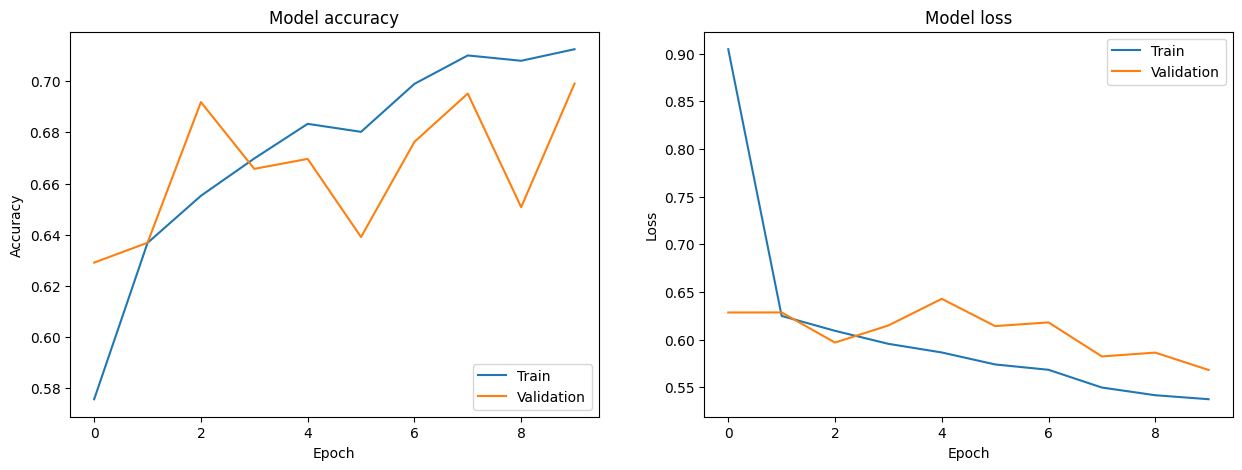

In [40]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

## **<font color="#A41034">Teacher Model (EfficientNet-B0) with wandb callback and using TF data as input</font>**

In [ ]:
## train & save weights into wandb.ai

## transfer learning from keras EfficientNet model weights

# Free up memory
K.clear_session()

if USE_EFFNETB0_AS_TEACHER:
  # invoke EfficientNet B0

  # use a larger learning rate
  learning_rate = 0.01

  # Load pre-trained EfficientNet-B0 model (excluding top layers)
  new_input = Input(shape=(img_height, img_width, img_channel))
  x = img_augmentation(new_input)
  base_model = EfficientNetB0(weights='imagenet', input_tensor=x, include_top=False)
  base_model.summary()

  # regularization to ease overfitting
  x = GlobalAveragePooling2D(name="avg_pool")(base_model.layers[-2].output)
  x = BatchNormalization()(x)
  x = Dropout(0.2, name="top_dropout")(x)                        ## drop out rate = 0.2

  # Add custom layers (3 FC layers with 1024 units and ReLU activation) on top of EfficientNet-B0
  x = Flatten()(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)

  # Add the final output layer with the desired number of classes and sigmoid activation
  output = Dense(units=1, activation='sigmoid')(x)

  # Create the final model by combining the VGG16 base model with the newly added layers
  teacher_model = Model(inputs=base_model.input, outputs=output, name=model_name+'_'+str(train_base))
  teacher_model.summary()

  # fix all weights in base_model
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model with appropriate loss, optimizer, and metrics
  teacher_model.compile(optimizer = Adam(learning_rate=learning_rate),
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

  # Initialize a W&B run
  wandb.init(
      project = 'rehab-ai-main',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model_name": teacher_model.name
      },
      name = teacher_model.name
  )

  # Train the model on the training data and validate on the validation data
  start_time = time.time()
  history = teacher_model.fit(train_data,
                            validation_data=validation_data,
                            callbacks=[WandbCallback()],
                            verbose=1,
                            epochs=epochs)

  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Update W&B
  wandb.config.update({"execution_time": execution_time})

  # Close the W&B run
  wandb.run.finish()

Model: "effnetb0_True"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 224, 224, 3)          0         ['input_16[0][0]']            
 al)                                                                                              
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['img_augmentation[7][0]']    
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]'

Epoch 1/10
     90/Unknown - 40s 342ms/step - loss: 5.9145 - acc: 0.6010

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 92s 934ms/step - loss: 5.9145 - acc: 0.6010 - val_loss: 0.6629 - val_acc: 0.6241
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.6673 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 81s 906ms/step - loss: 0.6673 - acc: 0.6163 - val_loss: 0.6628 - val_acc: 0.6241
Epoch 3/10
90/90 [==============================] - 46s 514ms/step - loss: 0.6667 - acc: 0.6163 - val_loss: 0.6628 - val_acc: 0.6241
Epoch 4/10
90/90 [==============================] - ETA: 0s - loss: 0.6680 - acc: 0.6156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 74s 831ms/step - loss: 0.6680 - acc: 0.6156 - val_loss: 0.6627 - val_acc: 0.6241
Epoch 5/10
90/90 [==============================] - 47s 524ms/step - loss: 0.6673 - acc: 0.6163 - val_loss: 0.6678 - val_acc: 0.6241
Epoch 6/10
90/90 [==============================] - 47s 527ms/step - loss: 0.7202 - acc: 0.6160 - val_loss: 0.6629 - val_acc: 0.6241
Epoch 7/10
90/90 [==============================] - ETA: 0s - loss: 0.6672 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 80s 900ms/step - loss: 0.6672 - acc: 0.6163 - val_loss: 0.6627 - val_acc: 0.6241
Epoch 8/10
90/90 [==============================] - ETA: 0s - loss: 0.6671 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 81s 904ms/step - loss: 0.6671 - acc: 0.6163 - val_loss: 0.6627 - val_acc: 0.6241
Epoch 9/10
90/90 [==============================] - ETA: 0s - loss: 0.6671 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 79s 888ms/step - loss: 0.6671 - acc: 0.6163 - val_loss: 0.6627 - val_acc: 0.6241
Epoch 10/10
90/90 [==============================] - ETA: 0s - loss: 0.6670 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_001959-zzs6cl3h/files/model-best)... Done. 0.2s


90/90 [==============================] - 77s 862ms/step - loss: 0.6670 - acc: 0.6163 - val_loss: 0.6626 - val_acc: 0.6241
Training execution time (mins) 11.775544897715251


acc,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁█▁▁▁▁▁
acc,0.61632
best_epoch,9
best_val_loss,0.66263
epoch,9
loss,0.66701
val_acc,0.6241


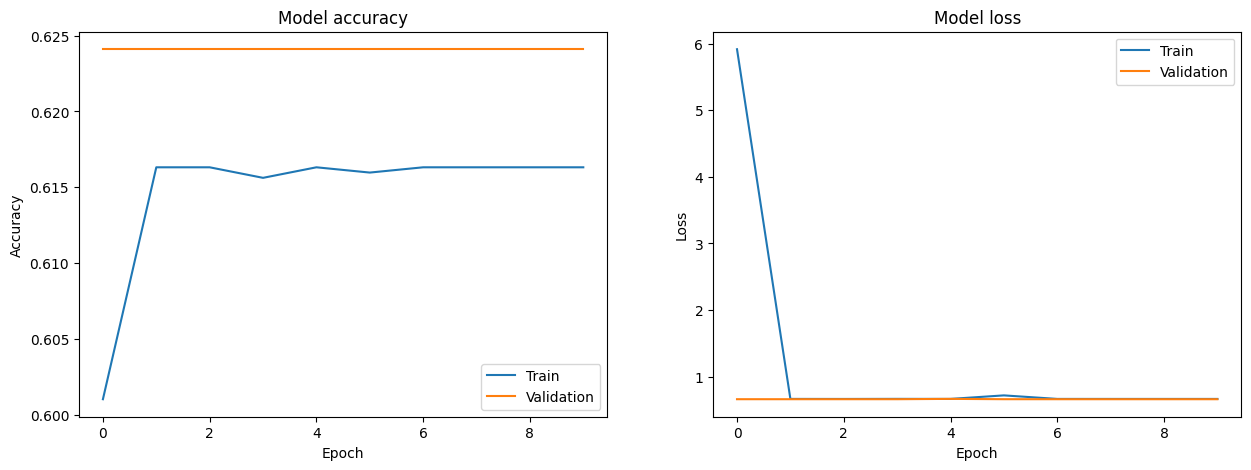

In [ ]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

## **<font color="#A41034">Teacher Model (EfficientNet-B7) with wandb callback and using TF data as input</font>**

In [ ]:
## train & save weights into wandb.ai

## transfer learning from keras EfficientNet model weights

# Free up memory
K.clear_session()

if USE_EFFNETB7_AS_TEACHER:
  # invoke EfficientNet B7

  # use a larger learning rate
  learning_rate = 0.01

  # Load pre-trained EfficientNet-B7 model (excluding top layers)
  new_input = Input(shape=(img_height, img_width, img_channel))
  x = img_augmentation(new_input)
  base_model = EfficientNetB7(weights='imagenet', input_tensor=x, include_top=False)
  base_model.summary()

  # regularization to ease overfitting
  x = GlobalAveragePooling2D(name="avg_pool")(base_model.layers[-2].output)
  x = BatchNormalization()(x)
  x = Dropout(0.2, name="top_dropout")(x)                        ## drop out rate = 0.2

  # Add custom layers (3 FC layers with 1024 units and ReLU activation) on top of EfficientNet-B0
  x = Flatten()(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dense(units=1024, activation='relu')(x)

  # Add the final output layer with the desired number of classes and sigmoid activation
  output = Dense(units=1, activation='sigmoid')(x)

  # Create the final model by combining the VGG16 base model with the newly added layers
  teacher_model = Model(inputs=base_model.input, outputs=output, name=model_name+'_'+str(train_base))
  teacher_model.summary()

  # fix all weights in base_model
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model with appropriate loss, optimizer, and metrics
  teacher_model.compile(optimizer = Adam(learning_rate=learning_rate),
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

  # Initialize a W&B run
  wandb.init(
      project = 'rehab-ai-main',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model_name": teacher_model.name
      },
      name = teacher_model.name
  )

  # Train the model on the training data and validate on the validation data
  start_time = time.time()
  history = teacher_model.fit(train_data,
                            validation_data=validation_data,
                            callbacks=[WandbCallback()],
                            verbose=1,
                            epochs=epochs)

  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Update W&B
  wandb.config.update({"execution_time": execution_time})

  # Close the W&B run
  wandb.run.finish()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 224, 224, 3)          0         ['input_27[0][0]']            
 al)                                                                                              
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]

Epoch 1/15
     90/Unknown - 212s 2s/step - loss: 27.1913 - acc: 0.5490

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_031230-vzvk2e54/files/model-best)... Done. 1.2s


90/90 [==============================] - 436s 5s/step - loss: 27.1913 - acc: 0.5490 - val_loss: 0.6745 - val_acc: 0.6241
Epoch 2/15
90/90 [==============================] - 299s 3s/step - loss: 0.6880 - acc: 0.6066 - val_loss: 0.6774 - val_acc: 0.6241
Epoch 3/15
90/90 [==============================] - ETA: 0s - loss: 0.6789 - acc: 0.6108

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_031230-vzvk2e54/files/model-best)... Done. 1.3s


90/90 [==============================] - 394s 4s/step - loss: 0.6789 - acc: 0.6108 - val_loss: 0.6629 - val_acc: 0.6241
Epoch 4/15
90/90 [==============================] - ETA: 0s - loss: 0.6690 - acc: 0.6128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_031230-vzvk2e54/files/model-best)... Done. 1.3s


90/90 [==============================] - 399s 4s/step - loss: 0.6690 - acc: 0.6128 - val_loss: 0.6621 - val_acc: 0.6241
Epoch 5/15
90/90 [==============================] - ETA: 0s - loss: 0.6852 - acc: 0.6153

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_031230-vzvk2e54/files/model-best)... Done. 1.3s


90/90 [==============================] - 413s 5s/step - loss: 0.6852 - acc: 0.6153 - val_loss: 0.6620 - val_acc: 0.6241
Epoch 6/15
90/90 [==============================] - 293s 3s/step - loss: 0.6742 - acc: 0.6142 - val_loss: 0.6628 - val_acc: 0.6241
Epoch 7/15
90/90 [==============================] - ETA: 0s - loss: 0.6712 - acc: 0.6163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231127_031230-vzvk2e54/files/model-best)... Done. 1.4s


90/90 [==============================] - 402s 4s/step - loss: 0.6712 - acc: 0.6163 - val_loss: 0.6620 - val_acc: 0.6241
Epoch 8/15
90/90 [==============================] - 301s 3s/step - loss: 0.6668 - acc: 0.6163 - val_loss: 0.6625 - val_acc: 0.6235
Epoch 9/15
90/90 [==============================] - 301s 3s/step - loss: 0.7079 - acc: 0.6181 - val_loss: 0.6670 - val_acc: 0.6241
Epoch 10/15
90/90 [==============================] - 296s 3s/step - loss: 0.6701 - acc: 0.6163 - val_loss: 0.6639 - val_acc: 0.6241
Epoch 11/15
90/90 [==============================] - 292s 3s/step - loss: 0.6789 - acc: 0.6160 - val_loss: 0.6628 - val_acc: 0.6235
Epoch 12/15
90/90 [==============================] - 285s 3s/step - loss: 0.6666 - acc: 0.6160 - val_loss: 0.6624 - val_acc: 0.6235
Epoch 13/15
90/90 [==============================] - 281s 3s/step - loss: 0.6666 - acc: 0.6163 - val_loss: 0.6628 - val_acc: 0.6241
Epoch 14/15
90/90 [==============================] - 282s 3s/step - loss: 0.6669 - acc: 0.

acc,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,███████▁██▁▁███
val_loss,▇█▁▁▁▁▁▁▃▂▁▁▁▁▁
acc,0.61632
best_epoch,6
best_val_loss,0.66198
epoch,14
loss,0.6664
val_acc,0.6241


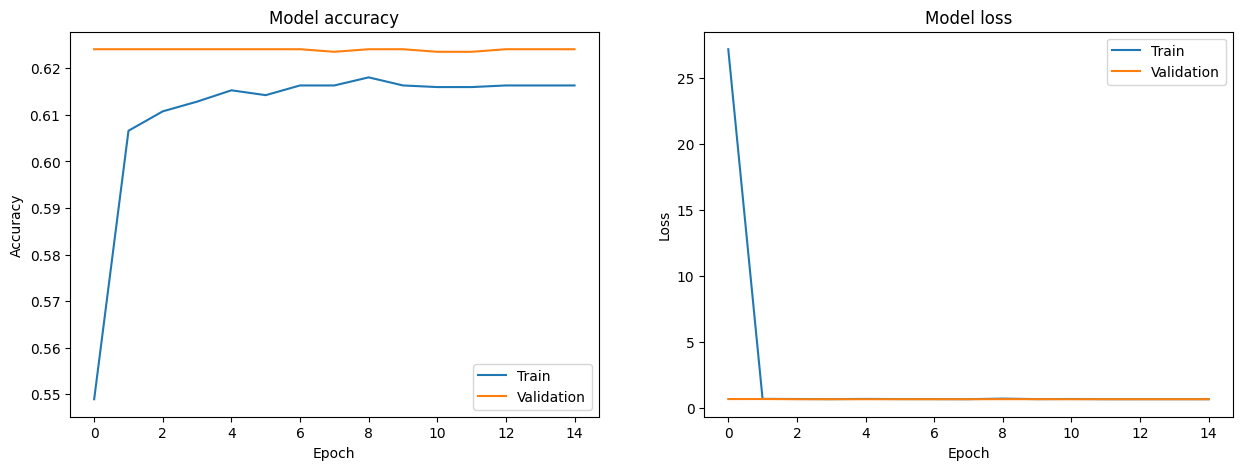

In [ ]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

## **<font color="#A41034">Teacher Model (mobilenet_v2) from tfhub.</font>**

#### **Build Teacher Model**

In [ ]:
if USE_MOBILENET_AS_TEACHER:

  def build_teacher_model(image_height, image_width, num_channels, num_classes):

    # Model input
    input_shape = [image_height, image_width, num_channels] # height, width, channels

    # Handle to pretrained model (Use a different model here)
    handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

    # Regularize using L1
    kernel_weight = 0.02
    bias_weight = 0.02

    model = Sequential([
          keras.layers.InputLayer(input_shape=input_shape),
                                  hub.KerasLayer(handle, trainable=False),
          keras.layers.Dense(units=64, activation='relu',
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)
                            ),
          keras.layers.Dense(units=num_classes-1,
                            kernel_regularizer=keras.regularizers.l1(kernel_weight),
                            bias_regularizer=keras.regularizers.l1(bias_weight)),
    ],name='teacher_model')

    return model

#### **Train Teacher**

In [41]:
############################
# Training Params
############################

if USE_MOBILENET_AS_TEACHER:
  learning_rate = 0.001
  initial_epoch = 0
  epochs = 500

  # Load pre trained model during demos
  LOAD_PREV_TRAINED = False

  # Free up memory
  K.clear_session()

  # Optimizer
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  # Loss
  #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  # Build or Load Model
  if not LOAD_PREV_TRAINED:
    # Build the teacher model
    teacher_model = build_teacher_model(img_height, img_width, num_channels, num_classes)
    print(teacher_model.summary())

    # Compile
    teacher_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[keras.metrics.BinaryAccuracy()])
                        # metrics=[keras.metrics.SparseCategoricalAccuracy()])

  else:
    # Load model
    teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
    print(teacher_model.summary())


    with open("distil_models/teacher_model_train_history.json") as json_file:
      prev_training_history = json.load(json_file)
    with open("distil_models/teacher_model_model_metrics.json") as json_file:
      model_metrics = json.load(json_file)

    epochs = len(prev_training_history["loss"])
    initial_epoch=epochs
    epochs=epochs+3 # Continue training for a few more epochs


  # Train model
  start_time = time.time()
  training_results = teacher_model.fit(
          train_data,
          validation_data=validation_data,
          epochs=epochs,
          initial_epoch=initial_epoch,
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

  # Get model training history
  training_history = training_results.history

  if LOAD_PREV_TRAINED:
    # Append previous training history & time
    training_history = append_training_history(training_results.history,
                                              prev_training_history,
                                              metrics=["loss","val_loss","binary_accuracy","val_binary_accuracy"])
    execution_time = model_metrics["execution_time"] + execution_time

  # Evaluate model
  evaluate_model(teacher_model,validation_data, training_history,execution_time,
                      learning_rate, batch_size, epochs, optimizer,
                      save=True,
                      loss_metrics=["loss","val_loss"],
                      acc_metrics=["binary_accuracy","val_binary_accuracy"])
                      #acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

## **<font color="#A41034">Build Student Model</font>**

#### **Student Model**
* 2 conv layers with max pooling and 1 dense layer

In [29]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        #keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
        keras.layers.Dense(units=num_classes-1, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train the Student model**
* 2 conv layers with max pooling and 1 dense layer
* for comparison purpose (pre-distillation)

Model: "student_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                              

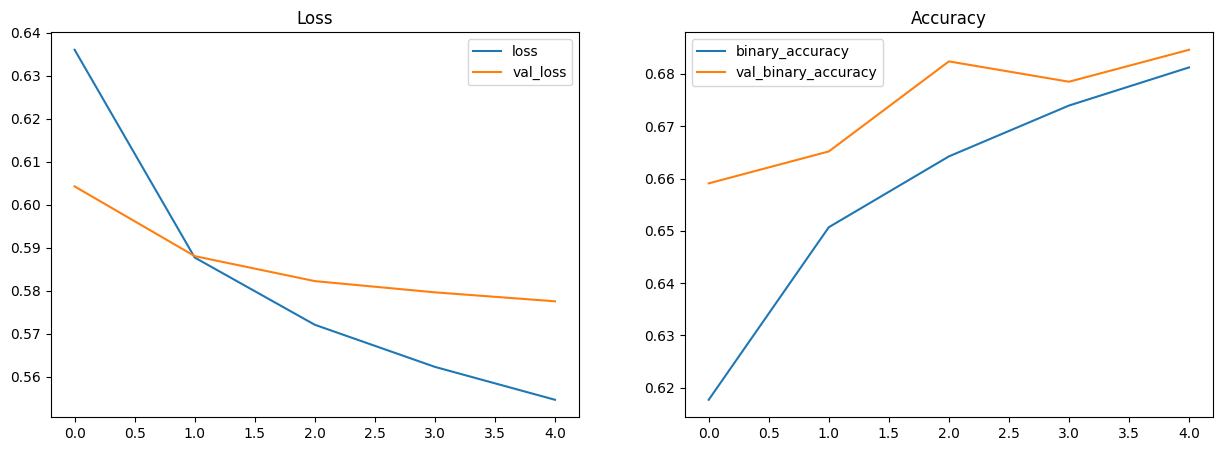

57/57 [==============================] - 1s 9ms/step - loss: 0.5775 - binary_accuracy: 0.6846
{'loss': 0.5775446891784668, 'binary_accuracy': 0.684619665145874}


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[0.5775446891784668, 0.684619665145874]

In [30]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(img_height, img_width, img_channel, 2, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.BinaryAccuracy()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["binary_accuracy","val_binary_accuracy"])



## **<font color="#A41034">Build Distiller</font>**

#### **Class definition**
**Distiller(Model)**
* **attribute:** Lambda, temperature
* **method:** compile(), train_step(), test_step()

In [42]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        if USE_VGG16_AS_TEACHER:
          ## VGG16 teacher outputs probability. So convert back to logit for temperature adjustment
          teacher_predict_prob = self.teacher(x, training=False)
          teacher_predictions = tf.math.log(teacher_predict_prob / (1 - teacher_predict_prob))
        else:
          teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
            #     tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
            #     tf.nn.softmax(student_predictions / self.temperature, axis=1),
                  tf.math.sigmoid(teacher_predictions / self.temperature),
                  tf.math.sigmoid(student_predictions / self.temperature)
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### **Knowlege distillation - plain (from teacher to student)**
* matching teacher output (prob) to student output (prob)

Model: "student_distill"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                              

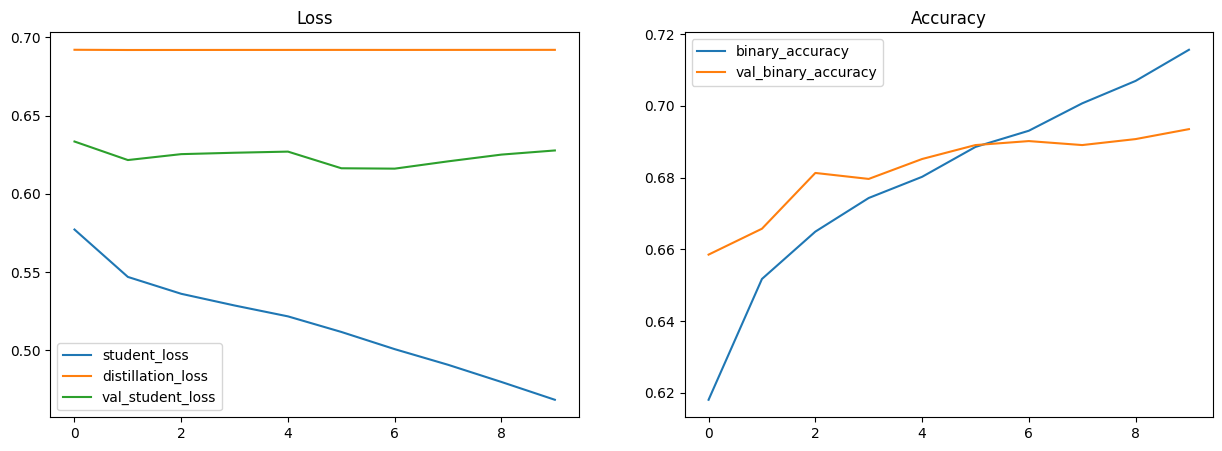

57/57 [==============================] - 1s 8ms/step - binary_accuracy: 0.6935 - student_loss: 0.5832


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


{'binary_accuracy': 0.6935036182403564, 'student_loss': 0.6277053356170654}


In [43]:
############################
# Training Params
############################
learning_rate = 0.001
#epochs = 35
epochs = 10
Lambda = 0.75
temperature= 12

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(img_height, img_width, img_channel, 2, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.BinaryCrossentropy(from_logits=True)

#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.BinaryCrossentropy(from_logits=False)

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.BinaryAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["binary_accuracy","val_binary_accuracy"])

# Save student model


save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)

## **<font color="#A41034">Other flavors of Distillation</font>**

### **Online distillation**
* This technique is also called as DML (Deep Mutual Learning)
* Knowlege is distilled among peers. No teacher is invovled.
* Original Paper: [Zhang 2018](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Deep_Mutual_Learning_CVPR_2018_paper.pdf).

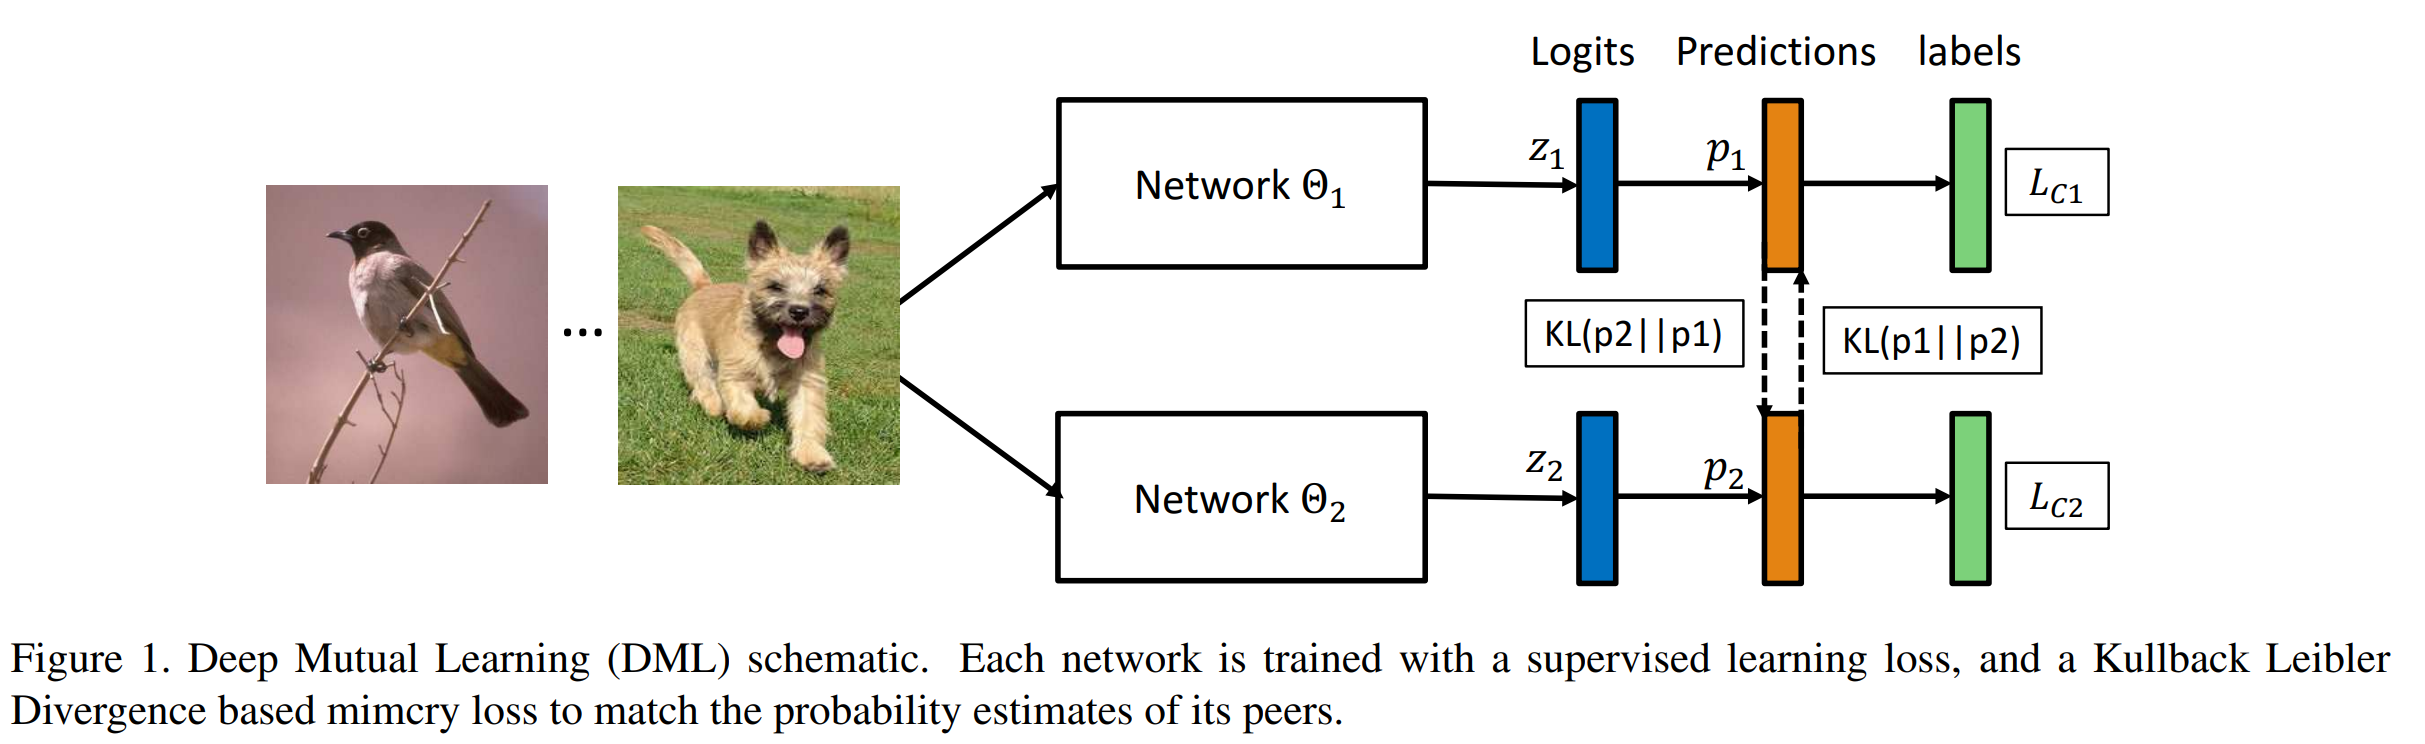

#### **Knowlege distillation - online distillation (2  students)**
* no teacher, 2 students, matching output (prob)

##### **<font color="#A41034">Build 2 Student Models</font>**

In [33]:
## For simplicity, let's try 2 identical students.
## But there is no requirement for both student models to be identical.
## The students can be in any architecture.

student_model_1 = build_student_model(img_height, img_width, img_channel, 2, model_name='student_DML_1')
print(student_model_1.summary())

student_model_2 = build_student_model(img_height, img_width, img_channel, 2, model_name='student_DML_2')
print(student_model_2.summary())

Model: "student_DML_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                

##### **<font color="#A41034">Build 2 Distillers (1 per student)</font>**



In [34]:
# Build the distiller models
distiller_model_1 = Distiller(student=student_model_1, teacher=student_model_2)  ## student_1 being taught by student_2
distiller_model_2 = Distiller(student=student_model_2, teacher=student_model_1)  ## student_2 being taught by student_1

## Define the loss functions
student_loss = keras.losses.BinaryCrossentropy(from_logits=True)
distillation_loss = keras.losses.KLDivergence()


##### **<font color="#A41034">Distill Among Students</font>**

Epoch 1/10
90/90 [==============================] - 4s 32ms/step - binary_accuracy: 0.6052 - student_loss: 0.7192 - distillation_loss: -0.0803 - val_binary_accuracy: 0.6485 - val_student_loss: 0.8393
Epoch 2/10
90/90 [==============================] - 3s 31ms/step - binary_accuracy: 0.6719 - student_loss: 0.6838 - distillation_loss: -0.0827 - val_binary_accuracy: 0.6730 - val_student_loss: 0.8328
Epoch 3/10
90/90 [==============================] - 3s 32ms/step - binary_accuracy: 0.6910 - student_loss: 0.6701 - distillation_loss: -0.0838 - val_binary_accuracy: 0.6818 - val_student_loss: 0.8006
Epoch 4/10
90/90 [==============================] - 3s 33ms/step - binary_accuracy: 0.7149 - student_loss: 0.6587 - distillation_loss: -0.0824 - val_binary_accuracy: 0.6941 - val_student_loss: 0.7923
Epoch 5/10
90/90 [==============================] - 3s 32ms/step - binary_accuracy: 0.7253 - student_loss: 0.6499 - distillation_loss: -0.0817 - val_binary_accuracy: 0.6924 - val_student_loss: 0.7922


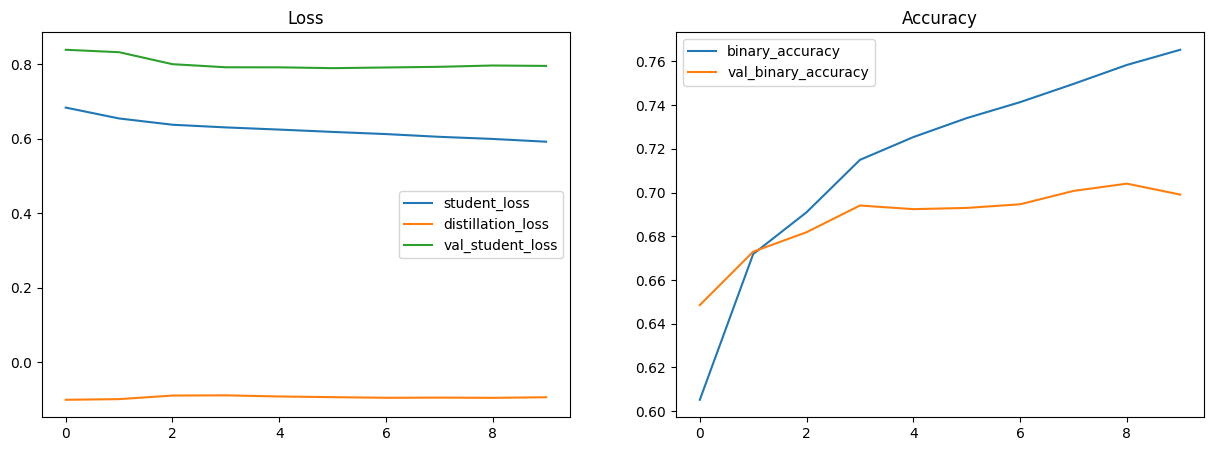

57/57 [==============================] - 1s 10ms/step - binary_accuracy: 0.6991 - student_loss: 0.6823


{'binary_accuracy': 0.699056088924408, 'student_loss': 0.7959492802619934}


In [35]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10
Lambda = 0.50                ## currently 1:1 ratio between cross_entropy loss & KL divergence loss
temperature= 1               ## original paper does not utilize soft label, hence, there is no concept of temperature.

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile
distiller_model_1.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.BinaryAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

distiller_model_2.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.BinaryAccuracy()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill among peers
start_time = time.time()
# training_results_1 = distiller_model_1.fit(
#         train_data,
#         validation_data=validation_data,
#         epochs=epochs,
#         verbose=1)
training_results_2 = distiller_model_2.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
# training_history_1 = training_results_1.history
training_history_2 = training_results_2.history

# Evaluate model
# evaluation_results_1 = evaluate_model(distiller_model_1,validation_data,
#                training_history_1,execution_time,learning_rate, batch_size, epochs, optimizer,
#                save=False,
#                loss_metrics=["student_loss","distillation_loss","val_student_loss"],
#                acc_metrics=["binary_accuracy","val_binary_accuracy"])
evaluation_results_2 = evaluate_model(distiller_model_2,validation_data,
               training_history_2,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["binary_accuracy","val_binary_accuracy"])

# Save student model
#save_model(student_model_1,training_history_1,execution_time,learning_rate, epochs, optimizer, evaluation_results_1)
save_model(student_model_2,training_history_2,execution_time,learning_rate, epochs, optimizer, evaluation_results_2)

#### **<font color="#A41034">Compare All Models</font>**

In [44]:
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"4,529",0.50 mins,0.80,69.91%,0.040 MB,0.001,32,10,Adam,student_DML_2
1,"4,529",17.31 mins,0.63,69.35%,0.040 MB,0.001,32,10,Adam,student_distill
2,"4,529",0.25 mins,0.58,68.46%,0.096 MB,0.001,32,5,Adam,student_scratch


#### **Knowlege distillation - online distillation (3  students)**
* no teacher, 3 students, matching output (prob)

### **Self Distillation**
* 1st iteration: 1 teacher + 1 student, matching output (prob)
* 2nd iteration and onwards: 1 student only

## **<font color="#A41034">Compare All Models</font>**

In [34]:
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"4,529",16.56 mins,0.63,69.24%,0.040 MB,0.001,32,10,Adam,student_distill
1,"4,529",0.19 mins,0.58,68.46%,0.096 MB,0.001,32,5,Adam,student_scratch


## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook

## **<font color="#A41034">template</font>**

#### **Utils**

Here are some util functions that we will be using for this notebook

#### **Utils**

Here are some util functions that we will be using for this notebook